## Importando dependências

In [1]:
import numpy as np
import sys
import pandas as pd
from pandas import DataFrame
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocessing as mp
from tensorflow.keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.losses import Loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Binarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, SMOTE

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Importando dataset e splitando em teste e treino

In [2]:
def normalize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    unique_labels = sorted(list(set(y)))
    for i in range(len(y)):
        y[i] = unique_labels.index(y[i])
    dataset.iloc[:, -1] = y
    
def binarize_dataset_labels(dataset):
    y = dataset.iloc[:, -1].values
    binarizer = Binarizer()
    y = binarizer.fit_transform([y])[0]
    dataset.iloc[:, -1] = y
    

HEADER = ["timestamp",'srcip', 'srcport', 'dstip', 'dstport', 'proto', 'total_fpackets', 'total_fvolume',
          'total_bpackets', 'total_bvolume', 'min_fpktl', 'mean_fpktl', 'max_fpktl', 'std_fpktl', 'min_bpktl',
          'mean_bpktl', 'max_bpktl', 'std_bpktl', 'min_fiat', 'mean_fiat', 'max_fiat', 'std_fiat', 'min_biat',
          'mean_biat', 'max_biat', 'std_biat', 'duration', 'min_active', 'mean_active', 'max_active', 'std_active',
          'min_idle', 'mean_idle', 'max_idle', 'std_idle', 'sflow_fpackets', 'sflow_fbytes', 'sflow_bpackets',
          'sflow_bbytes', 'fpsh_cnt', 'bpsh_cnt', 'furg_cnt', 'burg_cnt', 'total_fhlen', 'total_bhlen', "dscp", 'class']
initial_dataset_02_24 = pd.read_csv('dataset-oi-2017-02-24-summarized.csv', names=HEADER, header=1)
initial_dataset_02_25 = pd.read_csv('dataset-oi-2017-02-25-summarized.csv', names=HEADER, header=1)
initial_dataset_02_26 = pd.read_csv('dataset-oi-2017-02-26-summarized.csv', names=HEADER, header=1)
# initial_dataset_02_27 = pd.read_csv('dataset-oi-2017-02-27-summarized.csv', names=HEADER, header=1)
initial_dataset_02_28 = pd.read_csv('dataset-oi-2017-02-28-summarized.csv', names=HEADER, header=1)

initial_dataset_02_24 = initial_dataset_02_24.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_25 = initial_dataset_02_25.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_26 = initial_dataset_02_26.replace([np.inf, -np.inf], np.nan).dropna()
# initial_dataset_02_27 = initial_dataset_02_27.replace([np.inf, -np.inf], np.nan).dropna()
initial_dataset_02_28 = initial_dataset_02_28.replace([np.inf, -np.inf], np.nan).dropna()

initial_dataset = initial_dataset_02_24.append(initial_dataset_02_25, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_26, ignore_index=True)
# initial_dataset = initial_dataset.append(initial_dataset_02_27, ignore_index=True)
initial_dataset = initial_dataset.append(initial_dataset_02_28, ignore_index=True)

binarize_dataset_labels(initial_dataset)

## Criando modelo do nodee

In [16]:
class Node:
    def __init__(self, node_id = 123, dataset = DataFrame(list())):
        self.node_id = node_id
        self.local_dataset = dataset
        self.local_decision_tree = DecisionTreeClassifier(max_depth=20, criterion='gini')
        self.local_forest = [self.local_decision_tree]
        self.metrics_history = list()
        
    def apply_oversample(self, X, y):
        labels_counts = self.local_dataset['class'].value_counts()
        target_label = labels_counts.keys()[1]
        max_samples = int(labels_counts.values[0] * 0.6)
        current_samples = labels_counts.values[1]
        
        if current_samples >= max_samples:
            return X, y
        
        smote_oversample = SMOTE(sampling_strategy={target_label: max_samples}, random_state=0)
        return smote_oversample.fit_resample(X, y)

        
    def preprocess(self):
        X = self.local_dataset.iloc[:, 5:-1].values
        y = self.local_dataset.iloc[:, -1].values

#         X, y = self.apply_oversample(X, y)
                
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)        
        
    def train_decision_tree(self):
        self.local_decision_tree.fit(self.X_train, self.y_train)
        
    def test_decision_tree(self):
        y_pred = self.local_decision_tree.predict(self.X_test)
        
        self.local_decision_tree_prec = precision_score(self.y_test, y_pred)
        self.local_decision_tree_rec =recall_score(self.y_test, y_pred)
        self.local_decision_tree_f1 = f1_score(self.y_test, y_pred)
        
        self.local_decision_tree_acc = self.local_decision_tree.score(self.X_test, self.y_test)
        print(f"[INFO] Accuracy of node {self.node_id} tree = {self.local_decision_tree_acc}")
        
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)  

## Splitando dataset para os nodees participantes

In [18]:
import random
def split_dataset_non_iid(nodes):
        unique_ips = initial_dataset['srcip'].value_counts().head(100).keys()
        ips_range = len(unique_ips)
        node_index, id_list = (0,[])
        while node_index < num_nodes:
            srcip_id = random.randint(0,ips_range-1)
            if srcip_id not in id_list:
                id_list.append(srcip_id)
                local_dataset = initial_dataset.loc[initial_dataset['srcip'] == unique_ips[srcip_id]]
                value_counts = local_dataset['class'].value_counts()
                num_classes = len(value_counts)
                if num_classes > 1:
                    print(f"Value counts for node {node_index}\n{value_counts}")
                    nodes[node_index].local_dataset = local_dataset
                    node_index += 1

        
        
num_nodes = 30
nodes = [Node(node_id = i) for i in range(num_nodes)]  

split_dataset_non_iid(nodes)

Value counts for node 0
0.0    32381
1.0       24
Name: class, dtype: int64
Value counts for node 1
0.0    36937
1.0    14041
Name: class, dtype: int64
Value counts for node 2
0.0    28893
1.0     4486
Name: class, dtype: int64
Value counts for node 3
0.0    748473
1.0    303827
Name: class, dtype: int64
Value counts for node 4
0.0    49322
1.0     6579
Name: class, dtype: int64
Value counts for node 5
0.0    31725
1.0       47
Name: class, dtype: int64
Value counts for node 6
0.0    33545
1.0       52
Name: class, dtype: int64
Value counts for node 7
1.0    70512
0.0    64119
Name: class, dtype: int64
Value counts for node 8
0.0    24673
1.0     6947
Name: class, dtype: int64
Value counts for node 9
0.0    40708
1.0     1676
Name: class, dtype: int64
Value counts for node 10
0.0    42556
1.0       12
Name: class, dtype: int64
Value counts for node 11
0.0    83325
1.0      158
Name: class, dtype: int64
Value counts for node 12
0.0    196057
1.0      4698
Name: class, dtype: int64
Value

## Treinando e testando modelos RF locais

In [19]:
for node in nodes:
    node.preprocess()
    node.train_decision_tree()
    node.test_decision_tree()

print("[INFO] All local trains are finished!")

[INFO] Accuracy of node 0 tree = 0.9993828112945533
[[6475    1]
 [   3    2]]
[INFO] Accuracy of node 1 tree = 0.8764221263240487
[[7075  327]
 [ 933 1861]]
[INFO] Accuracy of node 2 tree = 0.9474236069502696
[[5695   77]
 [ 274  630]]
[INFO] Accuracy of node 3 tree = 0.8344293452437518
[[138484  11244]
 [ 23602  37130]]
[INFO] Accuracy of node 4 tree = 0.9759413290403363
[[9710  169]
 [ 100 1202]]
[INFO] Accuracy of node 5 tree = 0.9987411487018096
[[6335    5]
 [   3   12]]
[INFO] Accuracy of node 6 tree = 0.9992559523809523
[[6706    3]
 [   2    9]]
[INFO] Accuracy of node 7 tree = 0.8236714078805659
[[ 9719  3072]
 [ 1676 12460]]
[INFO] Accuracy of node 8 tree = 0.9149272612270715
[[4734  200]
 [ 338 1052]]
[INFO] Accuracy of node 9 tree = 0.9990562699068066
[[8161    2]
 [   6  308]]
[INFO] Accuracy of node 10 tree = 0.9997650927883486
[[8511    0]
 [   2    1]]
[INFO] Accuracy of node 11 tree = 0.9977840330598311
[[16645    17]
 [   20    15]]
[INFO] Accuracy of node 12 tree = 

## Compartilhando RFs e atualizando o conjunto de RFs


In [20]:
import random
for current in range(num_nodes):
    nodes[current].local_forest = [nodes[current].local_decision_tree]
    appended_trees, replaced_trees, acc_list = (0,0,[])
    print(f"Starting sharing for node {current}")
    for neighbour in range(num_nodes):
        if current != neighbour:
            neighbour_tree = nodes[neighbour].local_decision_tree
            acc = neighbour_tree.score(nodes[current].X_test, nodes[current].y_test)
            
            if len(nodes[current].local_forest) <= max_num_trees:
                nodes[current].local_forest.append(neighbour_tree)
                acc_list.append(acc)
                appended_trees += 1
            else:
                min_acc = min(acc_list)
                min_index = acc_list.index(min_acc) # seleciona a árvore de menor acurácia
#                 min_index = random.randint(0,max_num_trees-1) # seleciona uma árvore aleatória
                if min_acc < acc:
                    nodes[current].local_forest[min_index] = neighbour_tree # substitui a árvore pela nova
                    acc_list[min_index] = acc
                    replaced_trees += 1
    print(f"Node {current} appended {appended_trees} and replaced {replaced_trees} trees to forest")
    print(f"{acc_list}\n")
                

Starting sharing for node 0
Node 0 appended 10 and replaced 6 trees to forest
[0.99907421694183, 0.9975312451782132, 0.9956796790618732, 0.9989199197654683, 0.9989199197654683, 0.9979941367072983, 0.9992285141181917, 0.9961425705909582, 0.998611325412745, 0.9992285141181917]

Starting sharing for node 1
Node 1 appended 10 and replaced 10 trees to forest
[0.7288152216555512, 0.7763828952530404, 0.8006080816006277, 0.7903099254609651, 0.778932914868576, 0.7574539034915653, 0.7547077285209887, 0.8384660651235779, 0.7571596704590036, 0.7297959984307572]

Starting sharing for node 2
Node 2 appended 10 and replaced 7 trees to forest
[0.8629418813660875, 0.9095266626722588, 0.9231575793888556, 0.9239065308568005, 0.9185140802875974, 0.9189634511683643, 0.8623427201917315, 0.8656381066506891, 0.8636908328340324, 0.8641402037147993]

Starting sharing for node 3
Node 3 appended 10 and replaced 9 trees to forest
[0.7273828756058158, 0.7718853938990782, 0.7213199657892236, 0.7656466787037917, 0.74

## Testando o conjunto de RF dos nodees

In [23]:
from statistics import mode

def tree_predict(tree, row):
    return tree.predict([row])[0]

def forest_predict(forest, X):
    forest_prediction = list()
    pool = mp.Pool(mp.cpu_count())
    for row in X:        
        tree_predictions = pool.starmap(tree_predict, [(tree, row) for tree in forest])
        forest_prediction.append(mode(tree_predictions))
    return forest_prediction

for node in nodes:
    accuracy = Accuracy()
    forest_pred = forest_predict(node.local_forest, node.X_test)
    accuracy.update_state(node.y_test, forest_pred)
    node.local_forest_acc = accuracy.result().numpy()
    node.local_forest_prec= precision_score(node.y_test, forest_pred, zero_division=0)
    node.local_forest_rec = recall_score(node.y_test, forest_pred)
    node.local_forest_f1 = f1_score(node.y_test, forest_pred)

    print(f"[INFO] Accuracy of node {node.node_id} forest = {node.local_forest_acc}")

[INFO] Accuracy of node 0 forest = 0.9992285370826721
[INFO] Accuracy of node 1 forest = 0.7786386609077454
[INFO] Accuracy of node 2 forest = 0.9224086403846741
[INFO] Accuracy of node 3 forest = 0.7730257511138916
[INFO] Accuracy of node 4 forest = 0.904212474822998
[INFO] Accuracy of node 5 forest = 0.9977970123291016
[INFO] Accuracy of node 6 forest = 0.9980654716491699
[INFO] Accuracy of node 7 forest = 0.6010324358940125
[INFO] Accuracy of node 8 forest = 0.8105629086494446
[INFO] Accuracy of node 9 forest = 0.962958574295044
[INFO] Accuracy of node 10 forest = 0.9996476173400879
[INFO] Accuracy of node 11 forest = 0.9978439211845398
[INFO] Accuracy of node 12 forest = 0.9755423069000244
[INFO] Accuracy of node 15 forest = 0.9988861083984375
[INFO] Accuracy of node 16 forest = 0.8993303775787354
[INFO] Accuracy of node 17 forest = 0.8859480619430542
[INFO] Accuracy of node 18 forest = 0.9977137446403503
[INFO] Accuracy of node 19 forest = 0.9547562599182129
[INFO] Accuracy of nod

## Plotando resultados dos treinos locais

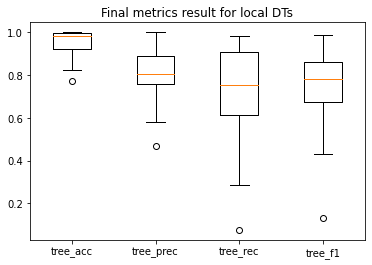

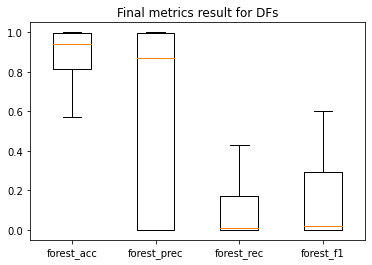

In [24]:
final_metrics = [[], [], [], [], [], [], [], []]
for node in nodes:
    final_metrics[0].append(node.local_decision_tree_acc)
    final_metrics[1].append(node.local_decision_tree_prec)
    final_metrics[2].append(node.local_decision_tree_rec)
    final_metrics[3].append(node.local_decision_tree_f1)
    final_metrics[4].append(node.local_forest_acc)
    final_metrics[5].append(node.local_forest_prec)
    final_metrics[6].append(node.local_forest_rec)
    final_metrics[7].append(node.local_forest_f1)

# Boxplot das árvores de decisão
plt.boxplot(final_metrics[:4])
plt.title('Final metrics result for local DTs')
plt.xticks([1, 2, 3, 4], ['tree_acc', 'tree_prec', 'tree_rec', 'tree_f1'])
plt.show()

# Boxplot das florestas de decisão
plt.boxplot(final_metrics[4:])
plt.title('Final metrics result for DFs')
plt.xticks([1, 2, 3, 4], ['forest_acc', 'forest_prec', 'forest_rec', 'forest_f1'])
plt.show()